#### Загрузка conllu датасета

In [1]:
from pathlib import Path
import requests

In [2]:
data_dir = Path.cwd() / "data"
serb_train = data_dir / "sr_set-ud-train.conllu"

if not data_dir.exists():
    data_dir.mkdir()

if not serb_train.exists():

    url = r"https://raw.githubusercontent.com/UniversalDependencies/UD_Serbian-SET/refs/heads/master/sr_set-ud-train.conllu"

    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()

    except requests.exceptions.RequestException as e:
        print(f"Download failed: {e}")

    else:
        with open(serb_train, "w", encoding="utf-8") as file:
            file.write(response.text)


### Подготовка данных
#### Парсинг conllu

In [3]:
from nltk.parse import DependencyGraph
import warnings
warnings.filterwarnings('ignore')

from tools.custom_types import ConlluDbRow

In [4]:
with open(serb_train, "r", encoding="utf-8") as file:
    data = file.read()

In [5]:
sents = [sent for sent in data.split("\n\n") if sent.strip()]

In [6]:
len(sents)

3328

In [7]:
marker = "# sent_id = "
ids = [
    "\n".join(
        filter(
            lambda line: line.strip().startswith(marker),
            sent.split("\n")
        )
    )[len(marker):]
    for sent
    in sents
]

In [8]:
marker = "# text = "
raw_texts = [
    "\n".join(
        filter(
            lambda line: line.strip().startswith(marker),
            sent.split("\n")
        )
    )[len(marker):]
    for sent
    in sents
]

In [9]:
sents = [
    "\n".join(
        filter(
            lambda line: line.strip()[0] != "#",
            sent.split("\n")
        )
    )
    for sent
    in sents
]


In [10]:
trees = [
    DependencyGraph(sent)
    for sent
    in sents
]

In [11]:
len(raw_texts), len(ids), len(trees)

(3328, 3328, 3328)

In [12]:
#  На id отсюда мяпятся db_id из нашего датасета

CONLLU_DB: dict[
    str,
    ConlluDbRow
] = {
    ids[i] : {
        "text": raw_texts[i],
        "tree": trees[i]
    }
    for i in range(len(ids))
}

#### Загрузка авторского датасета

In [13]:
import pandas as pd
import csv

In [14]:
df = pd.read_csv("./data/forms2sents.csv", sep="\t", quoting=csv.QUOTE_NONE, index_col=0)

In [15]:
df.head()

,lemma,word,aspect,disambig,db_id
0,bacati,baca,imp,imp,set-s2762
1,bacati,bacaju,imp,imp,set-s693
2,bacati,bacaju,imp,imp,set-s2765
3,bacati,bacaju,imp,imp,set-s3624
4,bacati,bacala,imp,imp,set-s2360


In [16]:
# Всего записей
len(df)

4959

In [17]:
# Кол-во лемм
len(set(df["lemma"]))

311

In [18]:
# Кол-во уникальных форм
len(set(map(str.lower, df["word"])))

1398

In [19]:
# Кол-во уникальных предложений.
len(set(df["db_id"]))

2605

In [20]:
# Самые частотные леммы
from collections import Counter
Counter(df["lemma"].values).most_common(10)

[('reći', 285),
 ('moći', 171),
 ('imati', 154),
 ('kazati', 143),
 ('trebati', 111),
 ('morati', 95),
 ('izjaviti', 90),
 ('dobiti', 61),
 ('postati', 61),
 ('želeti', 53)]

In [21]:
test_row = df.iloc[0]
test_row

lemma          bacati
word             baca
aspect            imp
disambig          imp
db_id       set-s2762
Name: 0, dtype: object

In [22]:
test_entry = CONLLU_DB[test_row["db_id"]]

In [23]:
test_entry["text"]

'Otpad iz šest priobalnih zemalja, kao i država u njegovom slivu, ulazi u more uglavnom preko reka, a ponekad se jednostavno baca u vodu.'

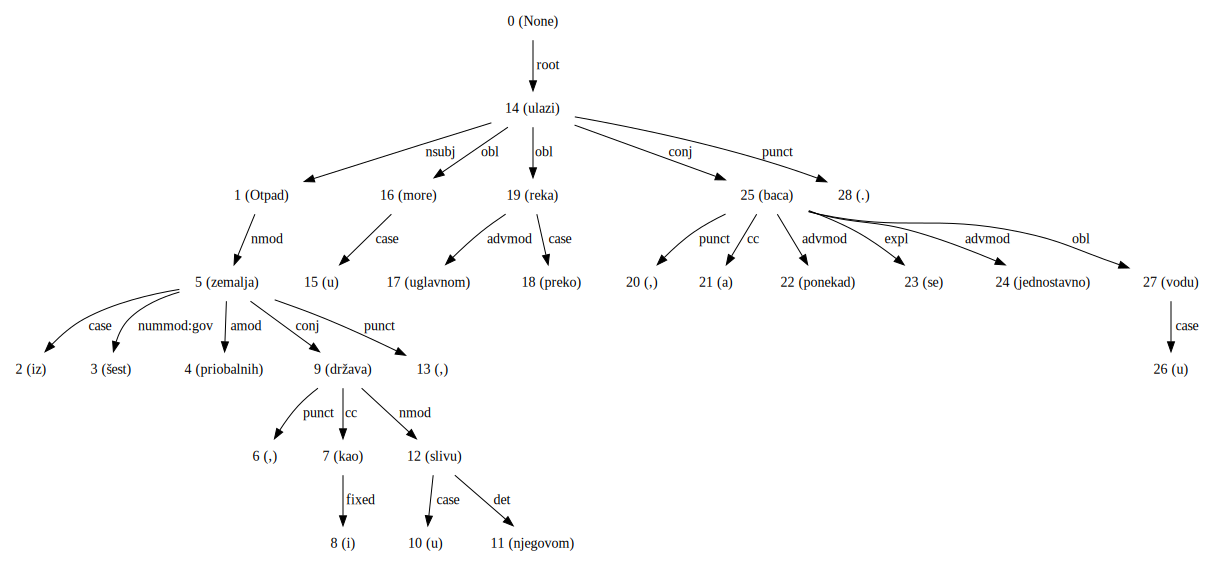

In [24]:
test_entry["tree"]

#### Из датасета удалены все случаи, где одна и та же форма глагола встречается в тексте несколько раз. Поэтому мы можем позволить себе искать ноду, в которой тусуется слово, только по форме собственно слова.

In [25]:
from tools.utils import get_verb_node
from tools.utils import get_all_grammar

In [26]:
test_node = get_verb_node(
    test_row["word"],
    test_entry
)
test_node

{'address': 25,
 'word': 'baca',
 'lemma': 'bacati',
 'ctag': 'VERB',
 'tag': 'Vmr3s',
 'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin',
 'head': 14,
 'deps': defaultdict(list,
             {'punct': [20],
              'cc': [21],
              'advmod': [22, 24],
              'expl': [23],
              'obl': [27]}),
 'rel': 'conj'}

In [27]:
get_all_grammar(test_node)

{'Mood': 'Ind',
 'Number': 'Sing',
 'Person': '3',
 'Tense': 'Pres',
 'VerbForm': 'Fin',
 'POS': 'VERB'}

In [28]:
test_node = get_verb_node(
    "može",
    CONLLU_DB["set-s119"]
)
test_node

{'address': 3,
 'word': 'može',
 'lemma': 'moći',
 'ctag': 'VERB',
 'tag': 'Vmr3s',
 'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin',
 'head': 0,
 'deps': defaultdict(list,
             {'nsubj': [1],
              'advmod': [2],
              'xcomp': [6],
              'conj': [12],
              'punct': [15, 26],
              'parataxis': [17]}),
 'rel': 'root'}

In [29]:
CONLLU_DB["set-s119"]["tree"].nodes[2]

{'address': 2,
 'word': 'ne',
 'lemma': 'ne',
 'ctag': 'PART',
 'tag': 'Qz',
 'feats': 'Polarity=Neg',
 'head': 3,
 'deps': defaultdict(list, {}),
 'rel': 'advmod'}

#### Код ниже создает большую таблицу

In [77]:
df_for_analysis = df[["lemma", "word", "aspect", "disambig", "db_id"]]
df_for_analysis["text"] = df["db_id"].apply(lambda elem: CONLLU_DB[elem]["text"])
df_for_analysis

,lemma,word,aspect,disambig,db_id,text
0,bacati,baca,imp,imp,set-s2762,"Otpad iz šest priobalnih zemalja, kao i država..."
1,bacati,bacaju,imp,imp,set-s693,Kosovski Srbi bacaju kamenje na vojnike KFOR-a...
2,bacati,bacaju,imp,imp,set-s2765,"""Umesto da bacaju mulj 25-30 km prema pučini, ..."
3,bacati,bacaju,imp,imp,set-s3624,Blokirani razgovori sa MMF bacaju senku na nek...
4,bacati,bacala,imp,imp,set-s2360,"Prve večeri, publika je bacala flaše na bosans..."
...,...,...,...,...,...,...
4954,živeti,živimo,imp,imp,set-s1415,"Ne možemo više da živimo sa njima""."
4955,živeti,živimo,imp,imp,set-s3726,Stranke uvek obećavaju i svaki put nas iznever...
4956,živeti,živimo,imp,imp,news-s165,Revolucije u tehnologiji doprinele su da potpu...
4957,živeti,živimo,imp,imp,news-s192,"Postavlja se nezaobilazno pitanje, kako se izv..."


#### Добавим всю глагольную грамматику

In [ ]:
tags = set()

for _, row in df.iterrows():
    node = get_verb_node(
        row["word"],
        CONLLU_DB[row["db_id"]]
    )

    tags.update(
        get_all_grammar(
            node
        )
    )
tags = sorted(tags)
tags

['Gender', 'Mood', 'Number', 'POS', 'Person', 'Tense', 'VerbForm', 'Voice']

In [ ]:
for tag in tags:
    df_for_analysis[tag] = None

for i, row in df_for_analysis.copy().iterrows():
    node = get_verb_node(row["word"], CONLLU_DB[row["db_id"]])
    grammar = get_all_grammar(node)

    for tag in tags:
        val = grammar.get(tag, None)
        df_for_analysis.loc[i, tag] = val
        row[tag] = val

df_for_analysis.head()

,lemma,word,aspect,disambig,db_id,text,Gender,Mood,Number,POS,Person,Tense,VerbForm,Voice
0,bacati,baca,imp,imp,set-s2762,"Otpad iz šest priobalnih zemalja, kao i država...",None,Ind,Sing,VERB,3,Pres,Fin,None
1,bacati,bacaju,imp,imp,set-s693,Kosovski Srbi bacaju kamenje na vojnike KFOR-a...,None,Ind,Plur,VERB,3,Pres,Fin,None
2,bacati,bacaju,imp,imp,set-s2765,"""Umesto da bacaju mulj 25-30 km prema pučini, ...",None,Ind,Plur,VERB,3,Pres,Fin,None
3,bacati,bacaju,imp,imp,set-s3624,Blokirani razgovori sa MMF bacaju senku na nek...,None,Ind,Plur,VERB,3,Pres,Fin,None
4,bacati,bacala,imp,imp,set-s2360,"Prve večeri, publika je bacala flaše na bosans...",Fem,None,Sing,VERB,None,Past,Part,Act


#### Добавим окна по 3 токена с каждой стороны

In [86]:
from nltk import RegexpTokenizer

In [87]:
tokenizer = RegexpTokenizer(r"\w+")

In [113]:
def get_window(text, target, tokenizer, len_=4):
    left = len_ // 2
    right = len_ // 2

    tokens:list[str] = tokenizer.tokenize(text)
    target_id = tokens.index(target)

    left_id = max(target_id-left, 0)
    left_part =  tokens[left_id:target_id]

    right_id = min(target_id+right+1, len(tokens))
    right_part = tokens[target_id+1:right_id]

    while len(left_part) < left:
        left_part = ["[PAD]"] + left_part

    while len(right_part) < right:
        right_part = right_part + ["[PAD]"]

    return left_part + right_part


In [114]:
df_for_analysis.iloc[0]["text"]

'Otpad iz šest priobalnih zemalja, kao i država u njegovom slivu, ulazi u more uglavnom preko reka, a ponekad se jednostavno baca u vodu.'

In [115]:
get_window(df_for_analysis.iloc[0]["text"], df_for_analysis.iloc[0]["word"], tokenizer, 6)

['ponekad', 'se', 'jednostavno', 'u', 'vodu', '[PAD]']

In [116]:
get_window(df_for_analysis.iloc[0]["text"], "iz", tokenizer, 6)

['[PAD]', '[PAD]', 'Otpad', 'šest', 'priobalnih', 'zemalja']

In [117]:
col_names = ["l_tok_3", "l_tok_2", "l_tok_1", "r_tok_1", "r_tok_2", "r_tok_3"]

for name in col_names:
    df_for_analysis[name] = None

for i, row in df_for_analysis.copy().iterrows():

    window = get_window(row["text"], row["word"], tokenizer, 6)
    for j, name in enumerate(col_names):
        df_for_analysis.loc[i, name] = window[j]

df_for_analysis.head()

,lemma,word,aspect,disambig,db_id,text,Gender,Mood,Number,POS,Person,Tense,VerbForm,Voice,l_tok_3,l_tok_2,l_tok_1,r_tok_1,r_tok_2,r_tok_3
0,bacati,baca,imp,imp,set-s2762,"Otpad iz šest priobalnih zemalja, kao i država...",None,Ind,Sing,VERB,3,Pres,Fin,None,ponekad,se,jednostavno,u,vodu,[PAD]
1,bacati,bacaju,imp,imp,set-s693,Kosovski Srbi bacaju kamenje na vojnike KFOR-a...,None,Ind,Plur,VERB,3,Pres,Fin,None,[PAD],Kosovski,Srbi,kamenje,na,vojnike
2,bacati,bacaju,imp,imp,set-s2765,"""Umesto da bacaju mulj 25-30 km prema pučini, ...",None,Ind,Plur,VERB,3,Pres,Fin,None,[PAD],Umesto,da,mulj,25,30
3,bacati,bacaju,imp,imp,set-s3624,Blokirani razgovori sa MMF bacaju senku na nek...,None,Ind,Plur,VERB,3,Pres,Fin,None,razgovori,sa,MMF,senku,na,nekada
4,bacati,bacala,imp,imp,set-s2360,"Prve večeri, publika je bacala flaše na bosans...",Fem,None,Sing,VERB,None,Past,Part,Act,večeri,publika,je,flaše,na,bosanski


#### Добавим графемы по 3 с каждой стороны

In [126]:
def get_graphemes(word: str, num=3) -> list[str]:

    left_side = []
    right_side = []
    for i in range(min(num, len(word))):
        left_side.append(word[i])
        right_side.append(word[::-1][i])

    while len(left_side) != num:
        left_side = left_side + ["[PAD]"]
        right_side = right_side+ ["[PAD]"]

    return left_side + right_side

In [127]:
get_graphemes("abcde")

['a', 'b', 'c', 'e', 'd', 'c']

In [128]:
get_graphemes("abc")

['a', 'b', 'c', 'c', 'b', 'a']

In [129]:
get_graphemes("ab")

['a', 'b', '[PAD]', 'b', 'a', '[PAD]']

In [130]:
col_names = ["l_gr_1", "l_gr_2", "l_gr_3", "r_gr_1", "r_gr_2", "r_gr_3"]

for name in col_names:
    df_for_analysis[name] = None

for i, row in df_for_analysis.copy().iterrows():

    graphemes = get_graphemes(row["word"].lower())
    for j, name in enumerate(col_names):
        df_for_analysis.loc[i, name] = graphemes[j]

df_for_analysis.head()

,lemma,word,aspect,disambig,db_id,text,Gender,Mood,Number,POS,...,l_tok_1,r_tok_1,r_tok_2,r_tok_3,l_gr_1,l_gr_2,l_gr_3,r_gr_1,r_gr_2,r_gr_3
0,bacati,baca,imp,imp,set-s2762,"Otpad iz šest priobalnih zemalja, kao i država...",None,Ind,Sing,VERB,...,jednostavno,u,vodu,[PAD],b,a,c,a,c,a
1,bacati,bacaju,imp,imp,set-s693,Kosovski Srbi bacaju kamenje na vojnike KFOR-a...,None,Ind,Plur,VERB,...,Srbi,kamenje,na,vojnike,b,a,c,u,j,a
2,bacati,bacaju,imp,imp,set-s2765,"""Umesto da bacaju mulj 25-30 km prema pučini, ...",None,Ind,Plur,VERB,...,da,mulj,25,30,b,a,c,u,j,a
3,bacati,bacaju,imp,imp,set-s3624,Blokirani razgovori sa MMF bacaju senku na nek...,None,Ind,Plur,VERB,...,MMF,senku,na,nekada,b,a,c,u,j,a
4,bacati,bacala,imp,imp,set-s2360,"Prve večeri, publika je bacala flaše na bosans...",Fem,None,Sing,VERB,...,je,flaše,na,bosanski,b,a,c,a,l,a


'Otpad iz šest priobalnih zemalja, kao i država u njegovom slivu, ulazi u more uglavnom preko reka, a ponekad se jednostavno baca u vodu.'

['ponekad', 'se', 'jednostavno', 'u', 'vodu', None]

[None, None, None, 'šest', 'priobalnih', 'zemalja']

['Gender', 'Mood', 'Number', 'POS', 'Person', 'Tense', 'VerbForm', 'Voice']

In [31]:
generated_df = pd.DataFrame()